# KNN, рак и спам
__Суммарное количество баллов: 10__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
import csv # для чтения csv-файлов
from scipy import spatial # реализация кд-дерева

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно.

In [5]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    f = open(path_to_csv, 'r')
    X = np.array([[]])
    y = np.array([[]])
    reader = csv.reader(f)
    for row in reader:
        list = [[]]
        label = 0
        for col in row:
            if col == 'label':
                break
            if col == 'M':
                label = 1
            if col != 'M' and col != 'B':
               list[0].append(float(col))

        if y[0].size == 0:
            y = np.array([label])
        else:
            y = np.append(y, [label])
        if X[0].size == 0:
            X = np.array(list)
        else:
            X = np.append(X, list, axis = 0)

    f.close()
    return X[:][:], y[1:]

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    f = open(path_to_csv, 'r')
    X = np.array([[]])
    y = np.array([[]])
    reader = csv.reader(f)
    k = 0
    for row in reader:
        if k == 0:
            k = 1
            continue
        list = [[]]
        for i in range(len(row)):
            if i != len(row)-1:
                list[0].append(float(row[i]))
            else:
                if y[0].size == 0:
                    y = np.array([int(row[i])])
                else:
                    y = np.append(y, [int(row[i])])

        if X[0].size == 0:
            X = np.array(list)
        else:
            X = np.append(X, list, axis = 0)

    f.close()
    return X[:][:], y[1:]

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [6]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    X_train = np.array([[]])
    X_test = np.array([[]])
    y_train = np.array([])
    y_test = np.array([])
    trainlist = []
    testlist = []
    train = int(ratio*len(y))

    for i in range(train):
        tr = random.randint(0, len(y)-1)
        while tr in trainlist:
            tr = random.randint(0, len(y)-1)

        trainlist.append(tr)

    for i in range(0, len(y)):
        if i not in trainlist:
            testlist.append(i)

    X_train = X[trainlist][:]
    X_test = X[testlist][:]
    y_train = y[trainlist]
    y_test = y[testlist]

    return X_train, y_train, X_test, y_test

### Задание 3 (3 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [7]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    classes = len(np.unique(list(y_pred) + list(y_true)))
    confusion = np.zeros((classes, classes))
    for i in range(len(y_pred)):
        confusion[int(y_pred[i])][int(y_true[i])] += 1

    precision = []
    recall = []
    accuracy = []

    sum = 0
    sum_diag = 0
    for i in range(classes):
        sum_diag += confusion[i][i]
        sum_hor = 0
        sum_vert = 0
        for j in range(classes):
            sum += confusion[i][j]
            sum_hor += confusion[i][j]
            sum_vert += confusion[j][i]

        precision.append(confusion[i][i]/sum_hor)
        recall.append(confusion[i][i]/sum_vert)
        accuracy.append(sum_diag/sum)
    return precision, recall, accuracy


Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [8]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [9]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 5  (5 баллов)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [10]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size =leaf_size
        self.tree = np.array([[]])
        self.y_train = np.array([])
        return

    def fit(self, X, y):
        self.tree = spatial.KDTree(X)
        self.y_train = y
        return
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        y_test = np.array([[]])
        pred = 0
        for el in X:
            inds = []
            if self.n_neighbors == 1:
                inds.append((self.tree.query(el, self.n_neighbors))[1])
            else:
                inds = ((self.tree.query(el, self.n_neighbors))[1])

            M = 0
            B = 0
            for i in range(len(inds)):
                if y_train[inds[i]] == 0:
                    M += 1
                else:
                    B += 1

            if (y_test[0].size) == 0:
                y_test = np.array([[M/(M+B), B/(M+B)]])
            else:
                tmp = [[]]
                tmp[0].append(M/(M+B))
                tmp[0].append(B/(M+B))
                y_test = np.append(y_test, tmp, axis = 0)
        return y_test
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных

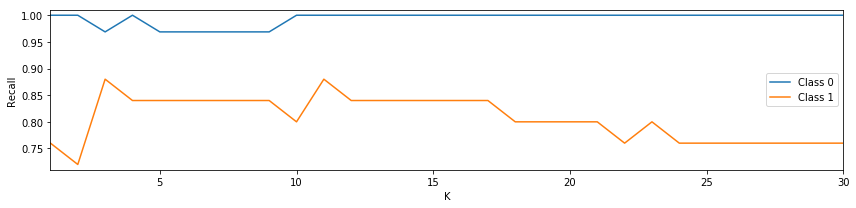

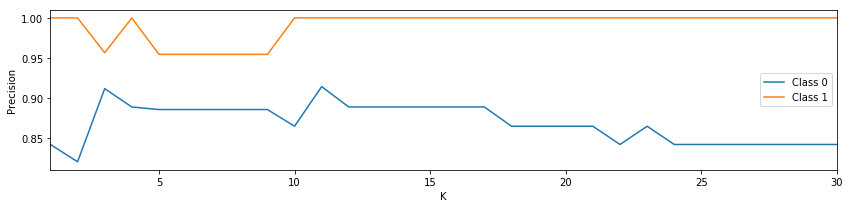

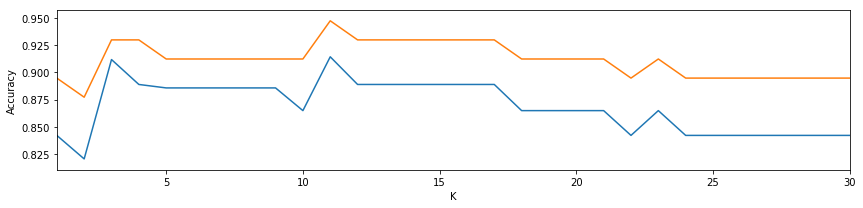

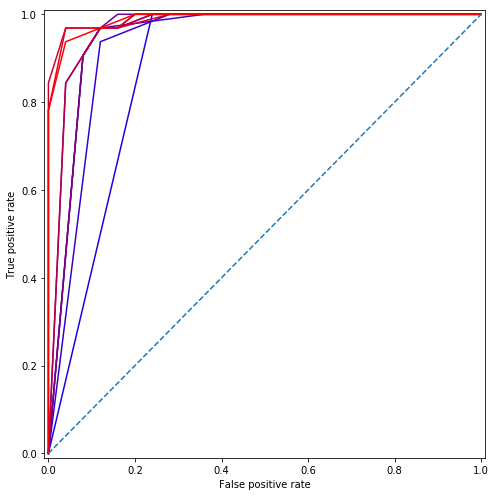

In [16]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

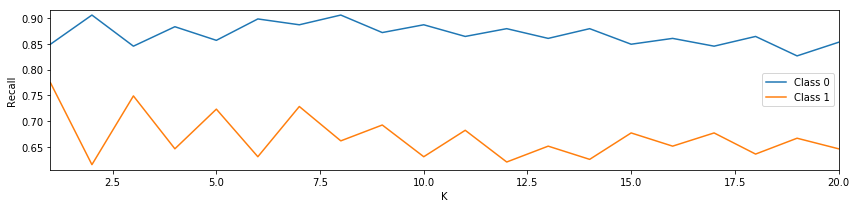

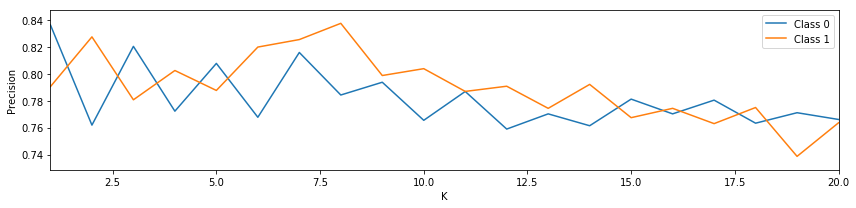

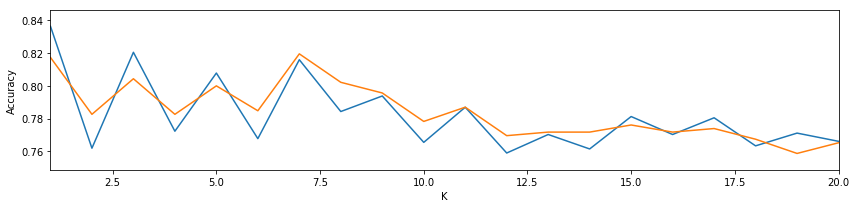

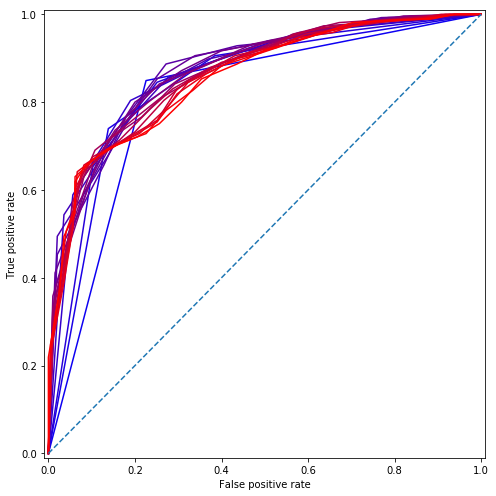

In [15]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)